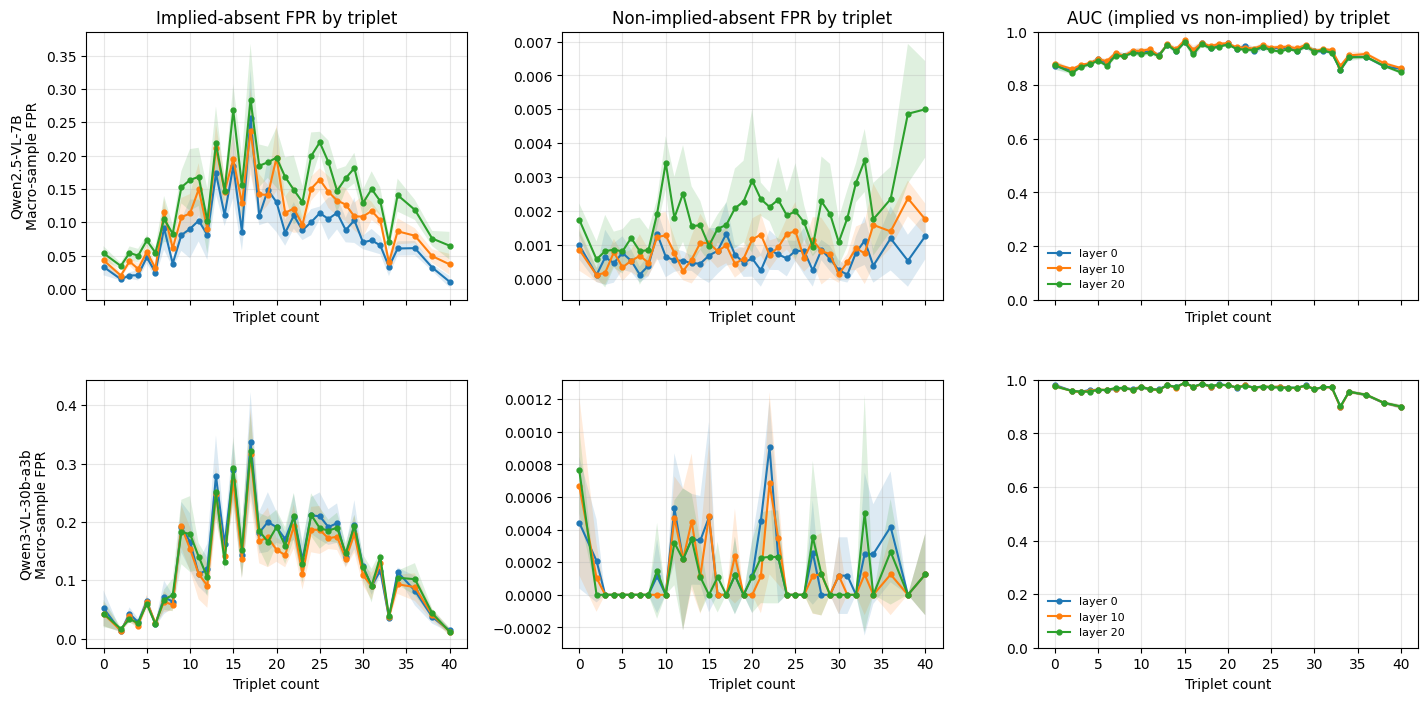

Saved:
- output/figures/triplet_metrics__qwen2-5-vl-7b__qwen3-vl-30b-a3b__impl-non-auc.png
- output/figures/triplet_metrics__qwen2-5-vl-7b__qwen3-vl-30b-a3b__impl-non-auc.pdf


In [2]:
# Cell: multi-model grid (each model = new row), panels as columns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.metrics import roc_auc_score

# --- CONFIG ---
MODEL_RUN_SUBDIRS = [
    "scene_description_balanced_2d_qwen2.5-VL-7B-Instruct",
    "scene_description_balanced_2d_qwen3-vl-30b-a3b-instruct",
]
SHOW_KEYS = ["impl", "non", "tot", "auc"]   # choose any subset/order
SHOW_KEYS = ["impl", "non", "auc"]  # remove total
FIG_W_PER_COL = 6.0
FIG_H_PER_ROW = 4.0

SAVE_DIR = Path("./output/figures")
DPI = 200
# -------------

def short_model_label(model_run_subdir: str) -> str:
    """
    Make model label short + descriptive for row/y-axis label.
    Examples:
      scene_description_balanced_2d_qwen2.5-VL-7B-Instruct -> Qwen2.5-VL-7B
      scene_description_balanced_2d_qwen3-vl-30b-a3b-instruct -> Qwen3-VL-30B-A3B
    """
    s = Path(model_run_subdir).name

    # Strip common prefixes you don't want to see
    s = re.sub(r"^scene_description_balanced_2d_", "", s, flags=re.IGNORECASE)

    # Strip instruct suffix
    s = re.sub(r"[-_]?instruct$", "", s, flags=re.IGNORECASE)
    s = re.sub(r"[-_]?Instruct$", "", s)

    # Normalize separators
    s = s.replace("_", "-")

    # Title-case the leading "qwen"
    s = re.sub(r"^qwen", "Qwen", s, flags=re.IGNORECASE)

    # Make VL uppercase consistently
    s = re.sub(r"\bvl\b", "VL", s, flags=re.IGNORECASE)

    # If you want a little more compactness, you can optionally remove extra dashes:
    # s = s.replace("--", "-")

    return s

def slugify(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"[^\w\-]+", "-", s)
    s = re.sub(r"-{2,}", "-", s)
    return s.strip("-")

def per_sample_auc_by_triplet(npz_path: Path):
    z = np.load(npz_path)
    triplet = z["triplet_count_per_sample"].astype(int)
    y_score = z["y_score"].astype(float)
    implied = z["y_implied_absent"].astype(bool)
    non_implied = z["y_non_implied_absent"].astype(bool)

    auc_s = np.full(triplet.shape[0], np.nan, dtype=float)
    for i in range(len(triplet)):
        mi, mn = implied[i], non_implied[i]
        if not mi.any() or not mn.any():
            continue
        s_implied = y_score[i, mi]
        s_non = y_score[i, mn]
        y = np.concatenate([np.ones(len(s_implied), dtype=int), np.zeros(len(s_non), dtype=int)])
        s = np.concatenate([s_implied, s_non])
        try:
            auc_s[i] = roc_auc_score(y, s)
        except ValueError:
            pass

    out = {}
    for t in np.unique(triplet):
        vals = auc_s[triplet == t]
        vals = vals[np.isfinite(vals)]
        out[int(t)] = float(vals.mean()) if len(vals) else np.nan
    return out

def macro_fpr_by_triplet(npz_path: Path):
    z = np.load(npz_path)
    triplet = z["triplet_count_per_sample"].astype(int)
    y_pred = z["y_pred"].astype(bool)
    implied = z["y_implied_absent"].astype(bool)
    non_implied = z["y_non_implied_absent"].astype(bool)

    fpr_impl_s = np.full(triplet.shape[0], np.nan, dtype=float)
    fpr_non_s  = np.full(triplet.shape[0], np.nan, dtype=float)
    fpr_tot_s  = np.full(triplet.shape[0], np.nan, dtype=float)

    for i in range(len(triplet)):
        mi = implied[i]
        mn = non_implied[i]
        mt = mi | mn
        if mi.any():
            fpr_impl_s[i] = y_pred[i, mi].mean()
        if mn.any():
            fpr_non_s[i] = y_pred[i, mn].mean()
        if mt.any():
            fpr_tot_s[i] = y_pred[i, mt].mean()

    out_impl, out_non, out_tot = {}, {}, {}
    for t in np.unique(triplet):
        m = triplet == t

        vi = fpr_impl_s[m]; vi = vi[np.isfinite(vi)]
        vn = fpr_non_s[m];  vn = vn[np.isfinite(vn)]
        vt = fpr_tot_s[m];  vt = vt[np.isfinite(vt)]

        out_impl[int(t)] = float(vi.mean()) if len(vi) else np.nan
        out_non[int(t)]  = float(vn.mean()) if len(vn) else np.nan
        out_tot[int(t)]  = float(vt.mean()) if len(vt) else np.nan

    return out_impl, out_non, out_tot

def agg(dicts):
    all_t = sorted({t for d in dicts for t in d.keys()})
    mat = np.array([[d.get(t, np.nan) for t in all_t] for d in dicts], dtype=float)
    return np.array(all_t), np.nanmean(mat, axis=0), np.nanstd(mat, axis=0)

PANELS = {
    "impl": ("Implied-absent FPR by triplet", "Macro-sample FPR"),
    "non":  ("Non-implied-absent FPR by triplet", "Macro-sample FPR"),
    "tot":  ("TOTAL absent FPR by triplet", "Macro-sample FPR"),
    "auc":  ("AUC (implied vs non-implied) by triplet", "AUC"),
}
show_keys = [k for k in SHOW_KEYS if k in PANELS]
if not show_keys:
    raise ValueError("SHOW_KEYS has no valid entries; use any of: impl, non, tot, auc")

def collect_by_layer_for_model(model_run_subdir: str):
    run_dir = Path("./output/probing_global") / model_run_subdir / "probes"
    inter_dir = run_dir / "intermediates"
    files = sorted(inter_dir.glob("X_*_seed*.npz"))

    by_layer = {}
    for f in files:
        m = re.match(r"(X_\d+)_seed(\d+)\.npz$", f.name)
        if not m:
            continue
        layer = int(m.group(1).split("_")[1])

        d_impl, d_non, d_tot = macro_fpr_by_triplet(f)
        d_auc = per_sample_auc_by_triplet(f)

        by_layer.setdefault(layer, {"impl": [], "non": [], "tot": [], "auc": []})
        by_layer[layer]["impl"].append(d_impl)
        by_layer[layer]["non"].append(d_non)
        by_layer[layer]["tot"].append(d_tot)
        by_layer[layer]["auc"].append(d_auc)

    return by_layer, inter_dir

# collect all models first
models_data = []
for model in MODEL_RUN_SUBDIRS:
    by_layer, inter_dir = collect_by_layer_for_model(model)
    models_data.append((model, short_model_label(model), by_layer, inter_dir))

n_rows = len(models_data)
n_cols = len(show_keys)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(FIG_W_PER_COL * n_cols, FIG_H_PER_ROW * n_rows),
    sharex=True, sharey=False,
    squeeze=False,
)

# Give extra left margin for multi-line y labels (prevents clipping/overlap)
fig.subplots_adjust(left=0.16, wspace=0.25, hspace=0.30)

for r, (model, model_lbl, by_layer, inter_dir) in enumerate(models_data):
    for c, key in enumerate(show_keys):
        ax = axes[r, c]
        title, ylabel = PANELS[key]

        if not by_layer:
            ax.text(0.5, 0.5, f"No files in\n{inter_dir}", ha="center", va="center")
            ax.set_axis_off()
            continue

        for layer in sorted(by_layer):
            xs, mean, std = agg(by_layer[layer][key])
            ax.plot(xs, mean, marker="o", linewidth=1.5, markersize=3.5, label=f"layer {layer}")
            ax.fill_between(xs, mean - std, mean + std, alpha=0.15)

        if r == 0:
            ax.set_title(title)

        ax.set_xlabel("Triplet count")

        # Put short model label + metric label ONLY on first column (one per row).
        if c == 0:
            ax.set_ylabel(f"{model_lbl}\n{ylabel}")
        else:
            ax.set_ylabel("")

        if key == "auc":
            ax.set_ylim(0.0, 1.0)

        ax.grid(alpha=0.3)

        # Legend only once per row (rightmost panel), reduces clutter.
        if c == n_cols - 1:
            ax.legend(fontsize=8, frameon=False, loc="best")

# --- SAVE FIG ---
SAVE_DIR.mkdir(parents=True, exist_ok=True)
models_slug = "__".join(slugify(short_model_label(m)) for m in MODEL_RUN_SUBDIRS)
panels_slug = "-".join(show_keys)
base = f"triplet_metrics__{models_slug}__{panels_slug}"

png_path = SAVE_DIR / f"{base}.png"
pdf_path = SAVE_DIR / f"{base}.pdf"

fig.savefig(png_path, dpi=DPI, bbox_inches="tight")
fig.savefig(pdf_path, bbox_inches="tight")

plt.show()

print(f"Saved:\n- {png_path}\n- {pdf_path}")


In [3]:
!pwd

/gpfs/helios/home/kelemnegasi/binding-open-vlm
